In [1]:
import sqlite3
import pandas as pd
from datetime import datetime

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

## Read data in from .db

These .db files are what I generated a few years back for my 'Intro to Data Analytics' subject at uni. 
Using these existing files will save me from redoing a lot of effort which I orginally put into scraping the data. 
However, I'm not quite sure at what state of the data processing this captured the data. The purpose of this is to see what state the data is in. 

In [3]:
con = sqlite3.connect('./Data/mydb.db')
# Gauges, Stations, Rainfall, Levels

In [4]:
df_stations = pd.read_sql('SELECT * FROM Stations', con)
df_gauges = pd.read_sql('SELECT * FROM Gauges', con)
df_rainfall = pd.read_sql('SELECT * FROM Rainfall', con, index_col=['station_id', 'date'])
df_levels = pd.read_sql('SELECT * FROM Levels', con, index_col=['gauge_id', 'date'])

In [5]:
display(df_stations.head())
display(df_gauges.head())
display(df_levels.head())
display(df_rainfall.head())

,id,name,opened_year,closed,lat,long,elev,state
0,46024,WILCANNIA (MURTEE),1923,None,-31.58,143.49,60,NSW
1,47019,MENINDEE POST OFFICE,1876,None,-32.39,142.42,61,NSW
2,47051,TANGRAMBALLY,1952,None,-34.50,143.67,-9999,NSW
3,47100,WENTWORTH LOCK 10 (MURRAY RIVER),1872,None,-34.11,141.90,-9999,NSW
4,48009,CARINDA (BOOROOMA),1881,None,-30.10,147.46,122,NSW


,id,name,lat,long,elev,NearestStat
0,201001,OXLEY RIVER AT EUNGELLA,-28.35370,153.293100,42.406,58193
1,201012,COBAKI CREEK AT COBAKI,-28.20120,153.458700,33.088,58163
2,201900,TWEED RIVER AT UKI,-28.41320,153.334300,52.297,58167
3,202001,BRUNSWICK RIVER AT DURRUMBUL (SHERRYS CROSSING),-28.53150,153.458000,42.143,58040
4,202002,BURRINGBAR CREEK AT BURRINGBAR,-28.43774,153.476761,47.441,58107


level  quality
gauge_id date                               
201001   1957-03-04 00:00:00  0.485      130
         1957-03-05 00:00:00  0.779      130
         1957-03-06 00:00:00  0.639      130
         1957-03-07 00:00:00  0.639      130
         1957-03-08 00:00:00  0.835      130

rainfall  period quality
station_id date                                         
46024      1923-02-01 00:00:00       0.0     NaN       Y
           1923-02-02 00:00:00       0.0     NaN       Y
           1923-02-03 00:00:00       0.0     NaN       Y
           1923-02-04 00:00:00       0.0     NaN       Y
           1923-02-05 00:00:00       0.0     NaN       Y

## Plot some examples

Here we plot river level and rainfall, just looking to get a feel for what the data looks like.

In [6]:
def plot_range(gauge, datemin, datemax):
    df_levels.loc[gauge].loc[datemin:datemax, 'level'].plot(title='River Level', xlabel='datetime', ylabel='River level (m)')
    plt.xticks(rotation=45)
    plt.show()
    nearest_station = df_gauges[df_gauges.id == gauge]['NearestStat'].values[0]
    df_rainfall.loc[nearest_station].loc[datemin:datemax, 'rainfall'].plot(title='Rainfall at nearest weather station', xlabel='datetime', ylabel='Rainfall (mm)')
    plt.xticks(rotation=45)

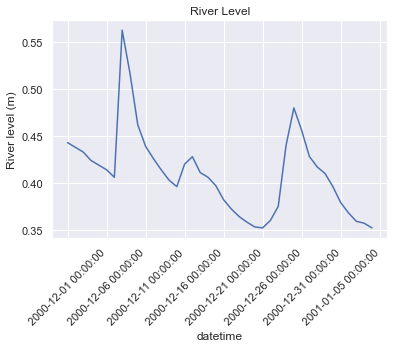

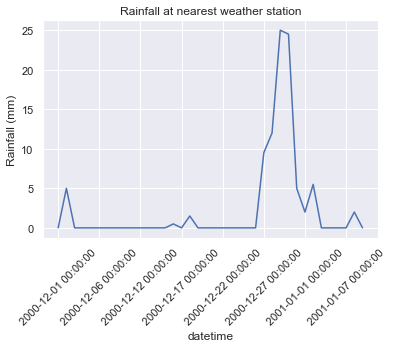

In [7]:
plot_range(gauge=201001, datemin='2000-12-01', datemax='2001-01-1')

In this example we look at the river gauge 'OXLEY RIVER AT EUNGELLA' in month of december 2000, along with it's nearest weather station. We see that the rainfall and previous river levels alone don't (intuitively) fully explain the future river levels. This could be because the rainfall at the nearest weather station is not representative of the rainfall in the catchment of this river. Or it might just be river level behaviour doesn't behave very intuitively all the time. Will need to look at more examples to get an idea of that.  

## Look at distribution of river levels

When I last used this data I normalised the levels data, so that levels were comparible between rivers. Not sure whether the data stored here is the normalised or unormalised levels. This can be checked by looking at the distribution of levels over a few rivers.

Run this a few times to get a feel for how the distribution of levels varies between rivers. 

(array([1.2216e+04, 8.5350e+03, 6.0300e+02, 1.3900e+02, 7.1000e+01,
        2.5000e+01, 1.6000e+01, 8.0000e+00, 1.0000e+00, 5.0000e+00]),
 array([0.012 , 0.4426, 0.8732, 1.3038, 1.7344, 2.165 , 2.5956, 3.0262,
        3.4568, 3.8874, 4.318 ]),
 <BarContainer object of 10 artists>)

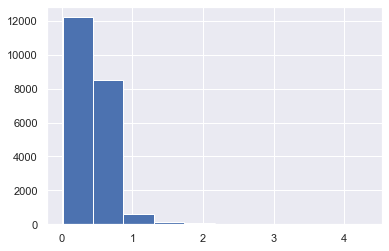

In [8]:
rand_gauge_id = df_gauges['id'].sample(1).values[0]
plt.hist(df_levels.loc[rand_gauge_id]['level'], bins=10)

This is definitely not normalised. For a example check out `rand_gauge_id=420901`

## Are nulls present?

Similarly to the normalisation, at some point the nulls and poor quality examples were removed from this dataset. However, I'm not sure if that was done before or after this particular dataset was exported. Have a quick look to check whether there are are nulls for rainfall or river levels. And if there are any reading which failed QA. 

In [9]:
df_rainfall[df_rainfall['rainfall'].isnull()]

,,rainfall,period,quality
station_id,date,,,


In [10]:
df_levels[df_levels['level'].isnull()]

,,level,quality
gauge_id,date,,


So there are no Null values for river level or rainfall, they have already been removed. 

In [11]:
df_levels[(df_levels['quality']==255) | (df_levels['quality']==201)]

,,level,quality
gauge_id,date,,


In [12]:
df_rainfall[(df_rainfall['quality']==255) | (df_rainfall['quality']==201)]

,,rainfall,period,quality
station_id,date,,,


There are also no values which failed QA. The quality field is a code, 255 is data unavailable, and 201 is no data exists. If any data existed with these quality codes it would be highly suspect. This data has already been removed. 

### Look at location of rainfall stations and gauges

Lets just make sure that the locations of these stations and guages looks vaguely correct on a map. 

In [13]:
import geopandas as gpd
import contextily as cx

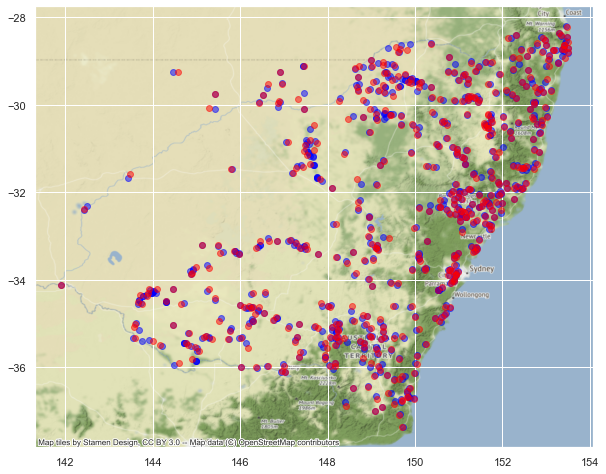

In [14]:
gdf_gauges = gpd.GeoDataFrame(df_gauges, geometry=gpd.points_from_xy(df_gauges.long, df_gauges.lat))
gdf_stations = gpd.GeoDataFrame(df_stations, geometry=gpd.points_from_xy(df_stations.long, df_stations.lat))
gdf_gauges.crs = "EPSG:4326"
gdf_stations.crs = "EPSG:4326"

ax = gdf_gauges.plot(figsize=(10,10), color='blue', alpha=0.5)
gdf_stations.plot(ax=ax, color='red', alpha=0.5)
cx.add_basemap(ax=ax, crs=gdf_gauges.crs)

We have rainfall stations in red and river level gauges in blue. Looks correct. Looks like we have good coverage of major rivers in NSW here.

One concern was that there would be some rural rivers which don't have a rainfall station anywhere nearby. But just visually we can see that there is always a rainfall station close to a river gauge. Can't remember if this was by design when I created the dataset, or whether this is just how the weather stations are located in NSW. Either way it works. 